<a href="https://colab.research.google.com/github/islammohamedd1/stock-prices-prediction/blob/main/notebooks/financial_news_setniment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import re

import IPython
import IPython.display

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Bidirectional, LSTM, GRU
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model 

from sklearn.model_selection import train_test_split

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/GP/Datasets/sentiment-analysis-for-financial-news.csv', names=['Label', 'Text'], encoding='latin-1')
df.head()

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df = df.drop(df[df['Label'] == 'neutral'].index)
df['Label'].unique()

array(['negative', 'positive'], dtype=object)

In [ ]:
df.replace('negative', 0, inplace=True)
df.replace('positive', 1, inplace=True)
df.head()

,Label,Text
2,0,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company 's updated strategy f...
5,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,1,"For the last quarter of 2010 , Componenta 's n..."


In [ ]:
df = df.reset_index()

In [ ]:
df.Label.unique()

array([0, 1])

In [ ]:
df.Text.str.len().describe()

count    1967.000000
mean      132.610574
std        55.431965
min        24.000000
25%        89.000000
50%       123.000000
75%       168.000000
max       298.000000
Name: Text, dtype: float64

In [ ]:
df.Label.value_counts()

1    1363
0     604
Name: Label, dtype: int64

# Text Preprocessing

In [ ]:
def replace_special_words(sentence):
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    return sentence

In [ ]:
df_text = [*map(replace_special_words , df['Text'].to_numpy())]

In [ ]:
labels = df.Label.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(df_text, labels, 
                                                    train_size=0.75, 
                                                    shuffle=True, 
                                                    random_state=1)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
vocab_size = 10000
sequence_length = 200

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

vectorize_layer.adapt(x_train)

# Word Embdeddings and RNN

## Word Embeddings with Dense Model

In [ ]:
embedding_dim=64

dense_model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

In [ ]:
dense_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = dense_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10)

Epoch 1/10
47/47 [==============================] - 1s 14ms/step - loss: 0.6897 - accuracy: 0.3058 - val_loss: 0.6854 - val_accuracy: 0.3110
Epoch 2/10
47/47 [==============================] - 0s 10ms/step - loss: 0.6816 - accuracy: 0.3058 - val_loss: 0.6782 - val_accuracy: 0.3110
Epoch 3/10
47/47 [==============================] - 0s 10ms/step - loss: 0.6746 - accuracy: 0.3058 - val_loss: 0.6716 - val_accuracy: 0.3110
Epoch 4/10
47/47 [==============================] - 0s 10ms/step - loss: 0.6682 - accuracy: 0.3058 - val_loss: 0.6660 - val_accuracy: 0.3110
Epoch 5/10
47/47 [==============================] - 0s 10ms/step - loss: 0.6623 - accuracy: 0.3058 - val_loss: 0.6607 - val_accuracy: 0.3110
Epoch 6/10
47/47 [==============================] - 0s 10ms/step - loss: 0.6571 - accuracy: 0.3058 - val_loss: 0.6556 - val_accuracy: 0.3110
Epoch 7/10
47/47 [==============================] - 0s 9ms/step - loss: 0.6522 - accuracy: 0.3058 - val_loss: 0.6512 - val_accuracy: 0.3110
Epoch 8/10
47/

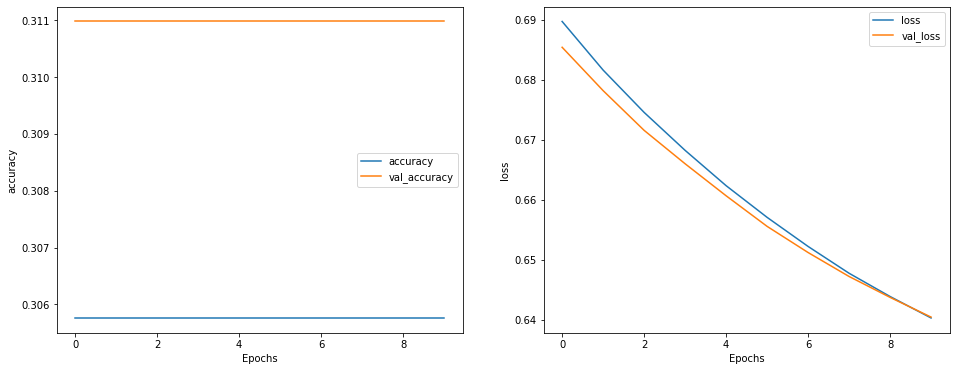

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## Word Embeddings with RNN

### LSTM

In [ ]:
tf.keras.backend.clear_session()

lstm_model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding",
             mask_zero=True),
    Bidirectional(LSTM(1024, return_sequences=True)),
    Bidirectional(LSTM(512)),
    Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Dense(1)
])

In [ ]:
lstm_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

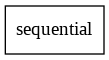

In [ ]:
plot_model(lstm_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
history = lstm_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=5)

Epoch 1/5
47/47 [==============================] - 25s 158ms/step - loss: 0.5780 - accuracy: 0.6664 - val_loss: 1.5357 - val_accuracy: 0.6545
Epoch 2/5
47/47 [==============================] - 4s 80ms/step - loss: 0.2577 - accuracy: 0.9092 - val_loss: 0.5178 - val_accuracy: 0.8110
Epoch 3/5
47/47 [==============================] - 4s 81ms/step - loss: 0.1022 - accuracy: 0.9661 - val_loss: 0.3740 - val_accuracy: 0.8618
Epoch 4/5
47/47 [==============================] - 4s 80ms/step - loss: 0.0643 - accuracy: 0.9769 - val_loss: 0.5028 - val_accuracy: 0.8638
Epoch 5/5
47/47 [==============================] - 4s 80ms/step - loss: 0.0464 - accuracy: 0.9878 - val_loss: 0.5557 - val_accuracy: 0.8435


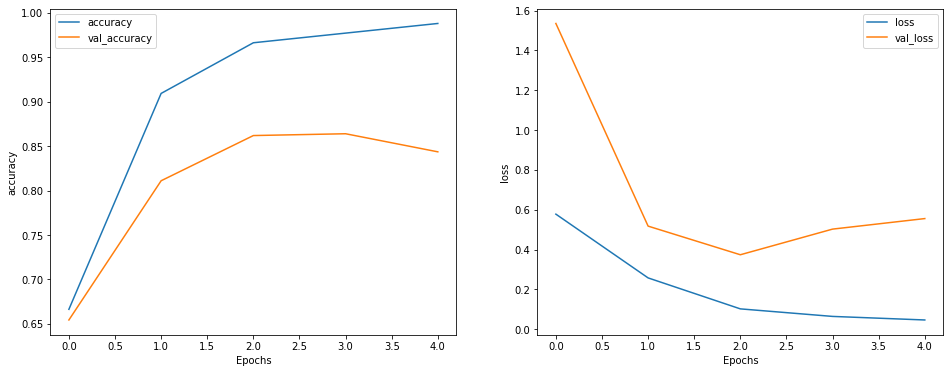

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
tf.keras.backend.clear_session()

gru_model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding",
             mask_zero=True),
    Bidirectional(GRU(1024, return_sequences=True)),
    Bidirectional(GRU(512)),
    Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Dense(1)
])

In [ ]:
gru_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = gru_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=5)

Epoch 1/5
47/47 [==============================] - 22s 143ms/step - loss: 0.5811 - accuracy: 0.6590 - val_loss: 0.6081 - val_accuracy: 0.6504
Epoch 2/5
47/47 [==============================] - 3s 69ms/step - loss: 0.2542 - accuracy: 0.9071 - val_loss: 0.4711 - val_accuracy: 0.8537
Epoch 3/5
47/47 [==============================] - 3s 69ms/step - loss: 0.1173 - accuracy: 0.9675 - val_loss: 0.5467 - val_accuracy: 0.8415
Epoch 4/5
47/47 [==============================] - 3s 69ms/step - loss: 0.0417 - accuracy: 0.9878 - val_loss: 0.6539 - val_accuracy: 0.8638
Epoch 5/5
47/47 [==============================] - 3s 69ms/step - loss: 0.0352 - accuracy: 0.9864 - val_loss: 0.5198 - val_accuracy: 0.8537


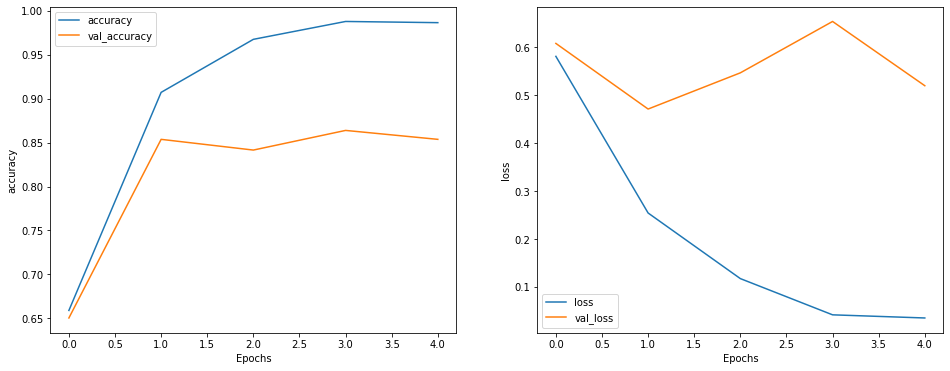

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Bert

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 4.3MB 14.8MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 14.0MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 38.2MB 1.2MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 358kB 49.5MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 686kB 47.5MB/s 
     |████████████████████████████████| 215kB 48.8MB/s 
     |████████████████████████████████| 645kB 49.0MB/s 
     |████████████████████████████████| 1.2MB 47.7MB/s 


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
def combile_and_fit_bert(tfhub_handle_encoder=tfhub_handle_encoder, 
                         tfhub_handle_preprocess=tfhub_handle_preprocess,
                         train_ds=train_ds, epochs=10):

    classifier_model = build_classifier_model()

    tf.keras.utils.plot_model(classifier_model)

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    print(f'Training model with {tfhub_handle_encoder}')
    history = classifier_model.fit(x_train,
                                y_train,
                                validation_data=(x_test, y_test),
                                epochs=epochs)
    return classifier_model, history

In [ ]:
def plot_loss_and_accuracy(history):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    print('val_acc', val_acc)

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

In [ ]:
val_accuracies = {}

## Small Bert
https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [ ]:
small_bert_model, history = combile_and_fit_bert()
val_accuracies['Small BERT'] = history.history['val_binary_accuracy']
IPython.display.clear_output()

small_bert_model.save('/content/drive/MyDrive/GP/models/bert/small_bert')

In [ ]:
plot_loss_and_accuracy(history)

## ALBERT
https://tfhub.dev/tensorflow/albert_en_base/2

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/albert_en_base/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
albert_model, history = combile_and_fit_bert(tfhub_handle_encoder, tfhub_handle_preprocess, epochs=20)
val_accuracies['ALBERT'] = history.history['val_binary_accuracy']

IPython.display.clear_output()

albert_model.save('/content/drive/MyDrive/GP/models/bert/albert')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/albert/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/albert/assets


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


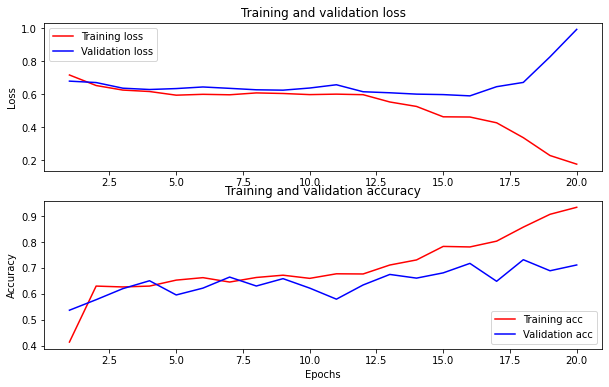

In [ ]:
plot_loss_and_accuracy(history)

## BERT uncased
https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
tf.keras.backend.clear_session()
bert_uncased_model, history = combile_and_fit_bert(tfhub_handle_encoder, tfhub_handle_preprocess, epochs=20)
val_accuracies['BERT Uncased'] = history.history['val_binary_accuracy']

IPython.display.clear_output()

bert_uncased_model.save('/content/drive/MyDrive/GP/models/bert/bert_uncased')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/bert_uncased/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/bert_uncased/assets


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


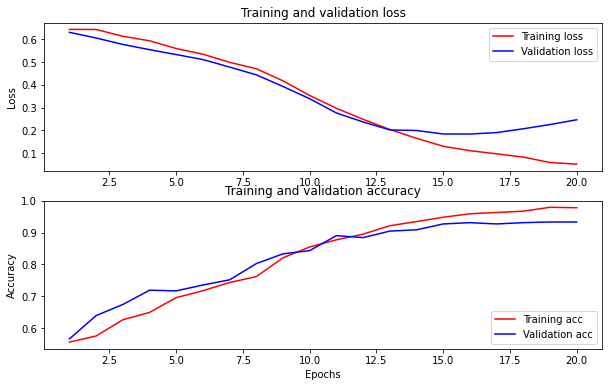

In [ ]:
plot_loss_and_accuracy(history)

## BERT cased
https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3'

In [ ]:
tf.keras.backend.clear_session()
bert_cased_model, history = combile_and_fit_bert(tfhub_handle_encoder, tfhub_handle_preprocess, epochs=10)
val_accuracies['BERT Cased'] = history.history['val_binary_accuracy']

IPython.display.clear_output()

bert_cased_model.save('/content/drive/MyDrive/GP/models/bert/bert_cased')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/bert_cased/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/bert_cased/assets


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
val_acc [0.30894309282302856, 0.7479674816131592, 0.8414633870124817, 0.922764241695404, 0.9471544623374939, 0.9593495726585388, 0.9654471278190613, 0.9634146094322205, 0.9613820910453796, 0.9593495726585388]


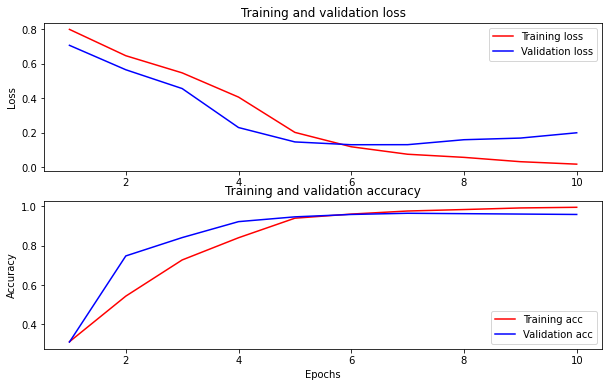

In [ ]:
plot_loss_and_accuracy(history)

## Electra Small
https://tfhub.dev/google/electra_small/2

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/google/electra_small/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
tf.keras.backend.clear_session()
electra_small_model, history = combile_and_fit_bert(tfhub_handle_encoder, tfhub_handle_preprocess, epochs=10)
val_accuracies['Elactra Small'] = history.history['val_binary_accuracy']

IPython.display.clear_output()

electra_small_model.save('/content/drive/MyDrive/GP/models/bert/electra_small')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/electra_small/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/electra_small/assets


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


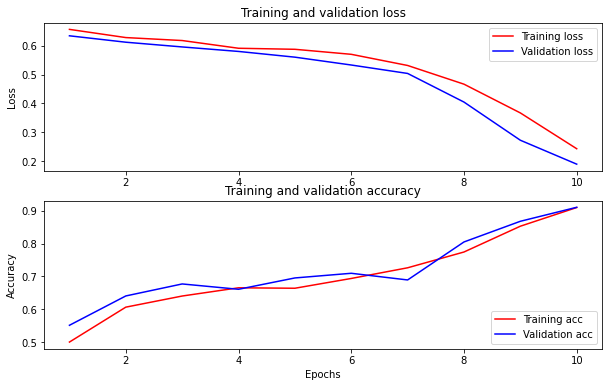

In [ ]:
plot_loss_and_accuracy(history)

## Elactra Base
https://tfhub.dev/google/electra_base/2

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/google/electra_base/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
tf.keras.backend.clear_session()
electra_base_model, history = combile_and_fit_bert(tfhub_handle_encoder, tfhub_handle_preprocess, epochs=10)
val_accuracies['Elactra Base'] = history.history['val_binary_accuracy']

IPython.display.clear_output()

electra_base_model.save('/content/drive/MyDrive/GP/models/bert/electra_base')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/electra_base/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/electra_base/assets


{'loss': [0.6332008838653564, 0.6178398728370667, 0.5948687791824341, 0.5469117164611816, 0.37308013439178467, 0.10837840288877487, 0.05827927961945534, 0.037551868706941605, 0.03183705732226372, 0.012760688550770283], 'binary_accuracy': [0.5301694869995117, 0.6352542638778687, 0.67254239320755, 0.7274576425552368, 0.8616949319839478, 0.9701694846153259, 0.9816949367523193, 0.9877966046333313, 0.9918643832206726, 0.9959322214126587], 'val_loss': [0.6228030323982239, 0.6014930009841919, 0.5694544315338135, 0.4874855577945709, 0.14542298018932343, 0.07982311397790909, 0.10053355246782303, 0.07961946725845337, 0.06909184157848358, 0.11680791527032852], 'val_binary_accuracy': [0.6117886304855347, 0.684959352016449, 0.7215447425842285, 0.7967479825019836, 0.9634146094322205, 0.9796748161315918, 0.9715447425842285, 0.977642297744751, 0.9817073345184326, 0.977642297744751]}
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


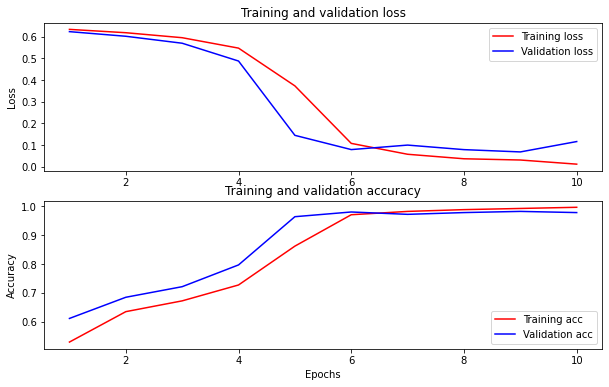

In [ ]:
print(history.history)
plot_loss_and_accuracy(history)

## Talking Heads
https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
tf.keras.backend.clear_session()
talking_heads_model, history = combile_and_fit_bert(tfhub_handle_encoder, tfhub_handle_preprocess, epochs=10)
val_accuracies['Talking Heads'] = history.history['val_binary_accuracy']

IPython.display.clear_output()

talking_heads_model.save('/content/drive/MyDrive/GP/models/bert/talking_heads')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/talking_heads/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/bert/talking_heads/assets


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


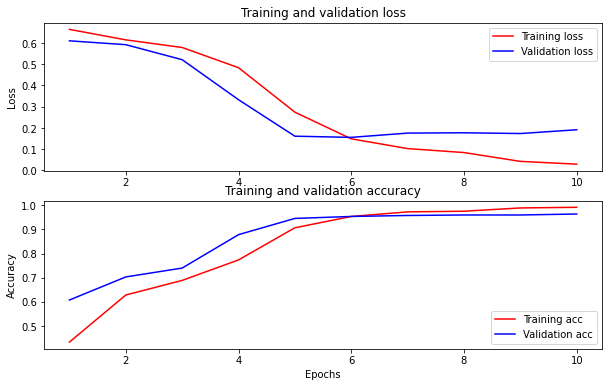

In [ ]:
plot_loss_and_accuracy(history)

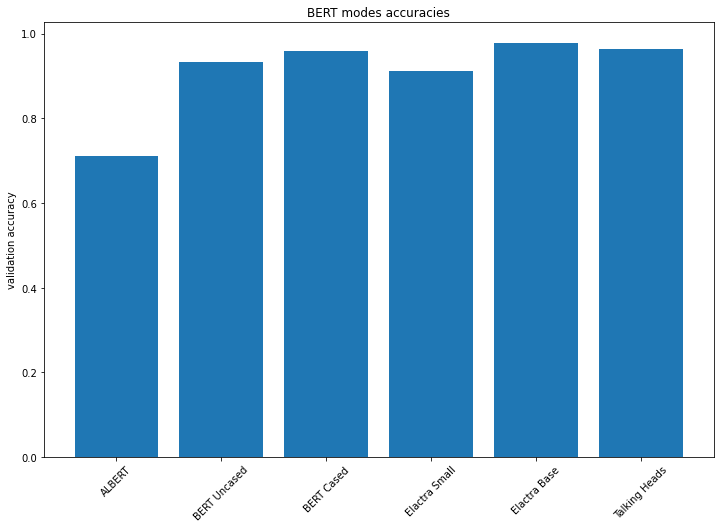

In [ ]:
x = np.arange(len(val_accuracies))


plt.figure(figsize=(12, 8))

accuracies = [val_accuracies[k][-1] for k in val_accuracies]

plt.ylabel('validation accuracy')
plt.title('BERT modes accuracies')

plt.bar(x, accuracies)
plt.xticks(ticks=x, labels=val_accuracies.keys(), rotation=45)
plt.show()

In [ ]:
val_accuracies

# Predict News Sentiment

In [ ]:
bert_model = tf.keras.models.load_model('/content/drive/MyDrive/GP/models/bert/bert_cased', compile=False)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  108310273   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

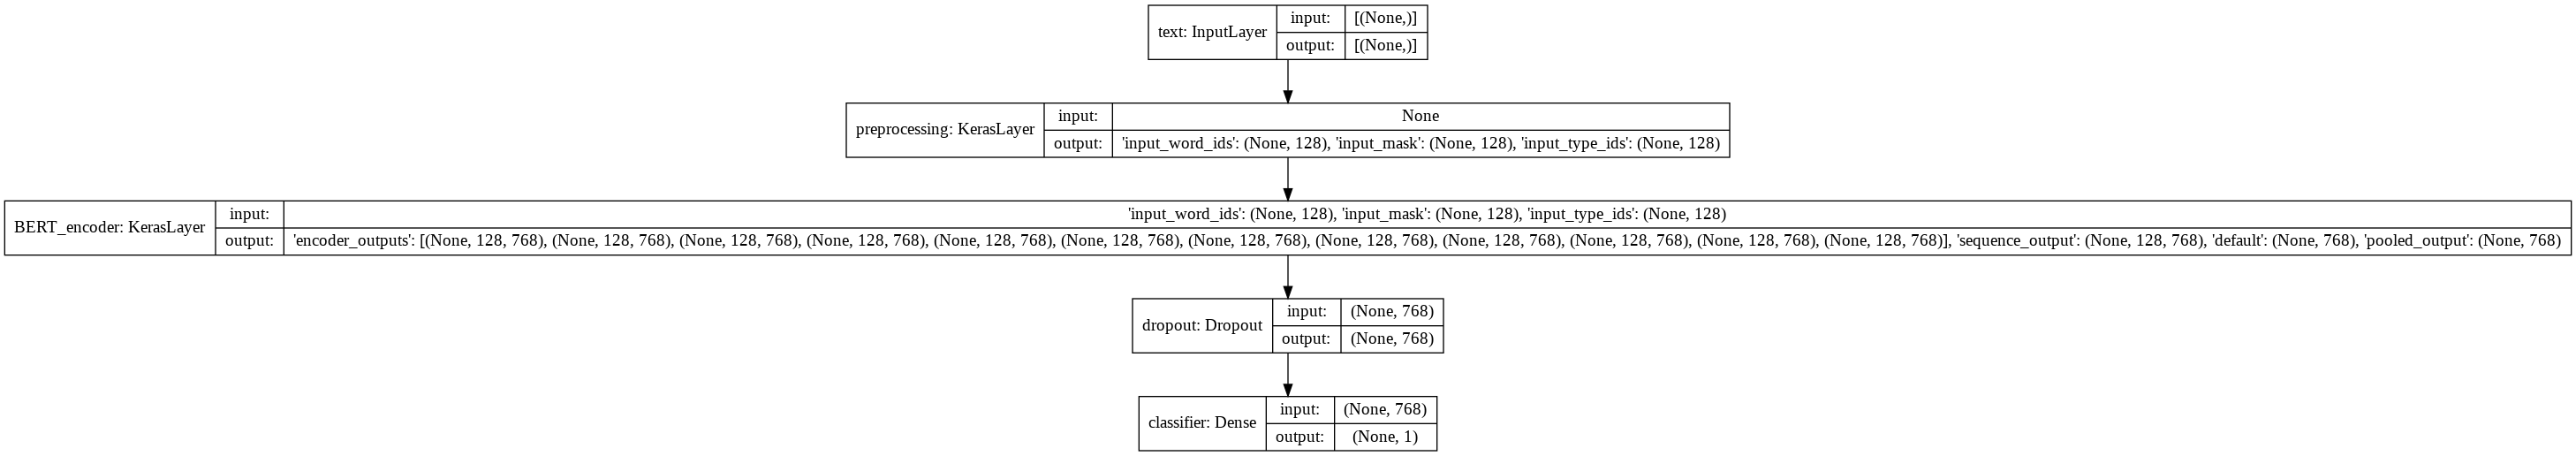

In [ ]:
plot_model(bert_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
# dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
news_df = pd.read_csv('/content/drive/MyDrive/GP/Datasets/daily-financial-news/analyst_ratings_processed.csv')
news_df = news_df[['title', 'date', 'stock']]
news_df.head()

,title,date,stock
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [ ]:
news_df['date'] = news_df['date'].astype(str)

In [ ]:
news_df['date'] = news_df['date'].apply(lambda x: x.split()[0])
news_df['date'] = pd.to_datetime(news_df['date'], format='%Y-%m-%d', errors='coerce')
news_df.dtypes

title            object
date     datetime64[ns]
stock            object
dtype: object

In [ ]:
news_df['title'][0]

'Stocks That Hit 52-Week Highs On Friday'

In [ ]:
news_ds = tf.data.Dataset.from_tensor_slices(np.array(news_df['title'].values))
news_ds = news_ds.batch(10)

In [ ]:
news_ds

<BatchDataset shapes: (None,), types: tf.string>

In [ ]:
news_df['sentiment'] = tf.sigmoid(bert_model.predict(news_ds, verbose=1, workers=-1, use_multiprocessing=True))

140047/140047 [==============================] - 13094s 93ms/step


In [ ]:
news_df.to_csv('/content/drive/MyDrive/GP/Datasets/analyzed_news.csv')

## Comparisons

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

### bert

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(x_test)

In [ ]:
y_pred = tf.sigmoid(bert_model.predict(x_test))

In [ ]:
accuracy_score(y_pred > 0.5, y_test)

0.959349593495935

In [ ]:
print(classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       153
           1       0.97      0.97      0.97       339

    accuracy                           0.96       492
   macro avg       0.95      0.95      0.95       492
weighted avg       0.96      0.96      0.96       492



### lstm

In [ ]:
lstm_y_pred = tf.sigmoid(lstm_model.predict(x_test))

In [ ]:
print(classification_report(y_test, lstm_y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74       153
           1       0.87      0.92      0.89       339

    accuracy                           0.85       492
   macro avg       0.83      0.81      0.82       492
weighted avg       0.85      0.85      0.85       492



### Assessing Vader

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
vader_scores = list(map(vader.polarity_scores, x_test))
vader_scores = list(map(lambda y: y['compound'], vader_scores))
vader_scores = np.array(vader_scores)

In [ ]:
accuracy_score(vader_scores > 0, y_test)

0.6747967479674797

In [ ]:
print(classification_report(y_test, vader_scores > 0))

              precision    recall  f1-score   support

           0       0.48      0.59      0.53       153
           1       0.80      0.71      0.75       339

    accuracy                           0.67       492
   macro avg       0.64      0.65      0.64       492
weighted avg       0.70      0.67      0.68       492

